In [33]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import numpy as np
import torch.nn as nn
import pandas as pd
import librosa
import librosa.display
from torch.utils.data import sampler
import torch.optim as optim
import json
import cv2
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from torchinfo import summary
from IPython.display import Audio
import IPython.display as ipd
import soundfile as sd
import padasip as dsp
import scipy
import scipy.signal

In [6]:
class DAPSDatasetHelper():
    #initialization 
    def __init__(self):
        self.sample_rate=8000
        fft_len=40
        hop_len=10
        self.dir= "./daps_dict_unet2.json"
        openfile=open(self.dir, "r")
        self.dataset_dict= json.load(openfile)
        indx=2
        self.keys={}
        for key  in self.dataset_dict.keys():
            if(key=="produced"):
                self.keys[1]=key
            else:
                self.keys[indx]=key
                indx+=1

        self.num_files_per_category=len(self.dataset_dict["produced"].keys())

    #get the indexed file and sample rate
    def get_indxd_file(self,indx,isLabel=False):
        if(isLabel):
            category=self.keys[1]
        else:
            #category=self.keys[np.random.randint(2,len(self.keys))]
            #consider one category for now
            category=self.keys[4]
        data=cv2.imread(self.dataset_dict[category][str(indx)],0)
        data= cv2.normalize(data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        Id= self.dataset_dict[category][str(indx)].split("/")[-1].split('.')[0]
        return (data,Id)

In [7]:
class FeatureExtractor():
    def __init__(self,fft_len,hop_size,sr):
        self.fft_len=int(fft_len*sr//1000)
        self.hop_size=int(hop_size*sr//1000)
        self.sr= sr
        self.spec_dims=(160,32)
        self.fft_buff=np.zeros((self.fft_len,1))
        self.ifft_buff=np.zeros((self.fft_len,1))
        self.wnd=np.hanning(self.fft_len)
        self.zbuf=np.zeros((self.hop_size,1))
        self.specgram=np.zeros((self.spec_dims[0],self.spec_dims[1]))

    def stft(self,x):
        R=self.hop_size
        M= self.fft_len
        x=x.reshape((x.shape[0],-1))
        self.fft_buff[M-R:,:]=x
        xw=np.multiply(self.fft_buff.T,self.wnd)
        fft_xw=np.fft.fft(xw,n=M).T
        self.fft_buff[:M-R,:]=self.fft_buff[R:,:]
        return fft_xw

    def istft(self,x):
        R=self.hop_size
        M= self.fft_len
        iift_xw= np.fft.ifft(x.T,self.fft_len)
        y=self.ifft_buff[:R]
        self.ifft_buff[:M-R]=self.ifft_buff[R:]
        self.ifft_buff[M-R:]=self.zbuf
        self.ifft_buff=self.ifft_buff+iift_xw.T
        return y.real
    
    def spectrogram(self,fft_x):
        self.specgram[:,:-1]=self.specgram[:,1:]
        self.specgram[:,-1]=np.abs(fft_x)[:self.spec_dims[0],0]
        y=cv2.normalize(self.specgram, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        #y=np.flip(y,0)
        return y
    

In [8]:
class DAPS(Dataset):
    def __init__(self):
        #super().__init__(self)
        self.daps= DAPSDatasetHelper()

    def __getitem__(self, index):
        data,id=self.daps.get_indxd_file(index)
        label,id=self.daps.get_indxd_file(index,True)
        return (data,label)

    def __len__(self):
        return (len(self.daps.keys)-1)*self.daps.num_files_per_category

In [9]:
dtype = torch.float32 # we will be using float throughout this tutorial
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [10]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [11]:
NUM_TRAIN=16000
NUM_VAL=2000
NUM_TEST=2000
print_every = 100
dataset_train = DAPS()
batch_size=16
loader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=8,
                          sampler=sampler.SequentialSampler(range(NUM_TRAIN)))
loader_val= DataLoader(dataset_train, batch_size=batch_size, num_workers=8,
                          sampler=sampler.SequentialSampler(range(NUM_TRAIN,NUM_VAL+NUM_TRAIN)))
loader_test = DataLoader(dataset_train, batch_size=batch_size, num_workers=8,
                          sampler=sampler.SequentialSampler(range(NUM_VAL+NUM_TRAIN, NUM_VAL+NUM_TRAIN+NUM_TEST)))

helper= DAPSDatasetHelper()


In [12]:
print(dataset_train.daps.keys)

{2: 'iphone_bedroom1', 3: 'iphone_balcony1', 4: 'ipad_confroom1', 5: 'clean', 6: 'iphone_livingroom1', 7: 'ipad_confroom2', 8: 'ipad_livingroom1', 9: 'cleanraw', 1: 'produced', 10: 'ipadflat_office1', 11: 'ipadflat_confroom1', 12: 'ipad_office1', 13: 'ipad_balcony1', 14: 'ipad_bedroom1', 15: 'sample', 16: 'ipad_office2'}


In [13]:
#Create Model classes
# create a class for linear layers 
class DenseLayer(nn.Module):
    def __init__(self,input_size,output_size,dropOut_p):
        super().__init__()
        self.dense=nn.Linear(input_size,output_size,bias=True)
        self.activation=nn.Tanh()
        self.dropOut=nn.Dropout(p=dropOut_p,inplace=False)
    
    def forward(self,x):
        y=self.dense(x)
        y=self.activation(y)
        y=self.dropOut(y)
        return y

#class for convolutional layers
class ConvLayer(nn.Module):
    def __init__(self,in_ch,out_ch,kernel_size,stride,padding,dropOut_p):
        super().__init__()
        self.conv=nn.Conv2d(in_ch,out_ch,kernel_size, stride=stride,padding=padding)
        self.activation=nn.ReLU()
        self.dropOut=nn.Dropout2d(p=dropOut_p,inplace=False)
    
    def forward(self,x):
        y=self.conv(x)
        y=self.activation(y)
        y=self.dropOut(y)

        return y

#RNN model for Residual echo suppression
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, fclayer_dim, output_dim, num_layers,dropout_prob):
        super().__init__()
        # Defining the number of layers and the nodes in each layer
        self.layer_dim=num_layers
        self.hidden_dim=hidden_dim
        self.rnn = nn.LSTM(
            fclayer_dim, hidden_dim, num_layers, batch_first=True
        )
        self.tanh=nn.Tanh()
        self.fc1= nn.Linear(input_dim,fclayer_dim)
        self.fc2= nn.Linear(hidden_dim,output_dim)
        self.sig=nn.Sigmoid()
        self.relu= nn.ReLU()


    def forward(self, x):
        
        y= self.fc1(x)

        y= self.tanh(y)
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, y.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(y)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        #out = out[:, -1, :]
        out=self.relu(out)
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc2(out)
        out = self.sig(out)
        return out

In [14]:
#SNR loss where yhat is average power spectrum of de-nonlinearised/denoised signal/ clean signal power 
def Loss_MSE(yhat,y,lossfn):
    target = torch.ones(1).to(device=device)
    #yhat=yhat.squeeze(0)
    #y=y.squeeze(0)
    #loss=lossfn(yhat,y,target)
    loss=lossfn(yhat,y)
    return loss


#SNR loss where yhat is average power spectrum of de-nonlinearised/denoised signal/ clean signal power 
def Loss_SNR(yhat,y):
    snr=0
    diff=y-yhat
    eps=10e-8
    for i in range (0,batch_size):
        yhat_T= diff[i,:,:]*diff[i,:,:]
        y_T=y[i,:,:]*y[i,:,:]
        Pyhat=torch.linalg.norm(yhat_T)
        Py=torch.linalg.norm(y_T)
        #snr+=torch.log10(Py/Pyhat)
        snr+=((Pyhat+eps)/Py)

    snr= torch.abs(snr/batch_size)
    return 0

In [15]:
class FeatureExtractor():
    def __init__(self,fft_len,hop_size,sr):
        self.fft_len=int(fft_len*sr//1000)
        self.hop_size=int(hop_size*sr//1000)
        self.sr= sr
        self.spec_dims=(160,32)
        self.fft_buff=np.zeros((self.fft_len,1))
        self.ifft_buff=np.zeros((self.fft_len,1))
        self.wnd=np.hanning(self.fft_len)
        self.zbuf=np.zeros((self.hop_size,1))
        self.specgram=np.zeros((self.spec_dims[0],self.spec_dims[1]))

    def stft(self,x):
        R=self.hop_size
        M= self.fft_len
        x=x.reshape((x.shape[0],-1))
        self.fft_buff[M-R:,:]=x
        xw=np.multiply(self.fft_buff.T,self.wnd)
        fft_xw=np.fft.fft(xw,n=M).T
        self.fft_buff[:M-R,:]=self.fft_buff[R:,:]
        return fft_xw

    def istft(self,x):
        R=self.hop_size
        M= self.fft_len
        iift_xw= np.fft.ifft(x.T,self.fft_len)
        y=self.ifft_buff[:R]
        self.ifft_buff[:M-R]=self.ifft_buff[R:]
        self.ifft_buff[M-R:]=self.zbuf
        self.ifft_buff=self.ifft_buff+iift_xw.T
        return y.real
    
    def spectrogram(self,fft_x):
        self.specgram[:,:-1]=self.specgram[:,1:]
        self.specgram[:,-1]=np.abs(fft_x)[:self.spec_dims[0],0]
        y=cv2.normalize(self.specgram, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        #y=np.flip(y,0)
        return y
    

In [16]:
def check_accuracy(loader, model,lossfn):
    print('Checking accuracy on validation set')
    model.eval()  # set model to evaluation mode
    mse=0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            x=torch.permute(x, (0, 2, 1))
            y=torch.permute(y, (0, 2, 1))
            pw_x=x*x

            # Forward pass: compute scores and loss
            mask = model(pw_x)

            yhat= mask*x
            #yhat=yhat[:,:,:,-1]
            #y=y[:,:,:,-1]
            loss_snr = Loss_SNR(yhat, y)
            loss_mse=Loss_MSE(yhat,y,lossfn)

            loss= loss_snr + loss_mse

            mse+= loss
        mse = mse / len(loader)
        print("Validation loss is", mse.cpu().numpy())
        return  mse.cpu().numpy()

In [17]:
print_every=1
def train_model(model, optimizer, scheduler ,epochs=1):
    """
    Train a model on DAPS.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: val loss and train loss
    """
    val_loss=[]
    train_loss=[]
    #lossfn=nn.CosineEmbeddingLoss(margin=0,reduction="mean")
    lossfn=nn.MSELoss()
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        running_loss = 0
        for t, (x, y) in enumerate(loader_train):
            
            #print(y.shape)          
            #iterate over each stft frame 
            x=x.to(device=device, dtype=dtype)
            y=y.to(device=device, dtype=dtype)
            
            x=torch.permute(x, (0, 2, 1))
            y=torch.permute(y, (0, 2, 1))
            
            pw_x=x*x

            # Forward pass: compute scores and loss
            mask = model(pw_x)

            #print(mask.shape)

            yhat= mask*x

            #yhat=yhat[:,:,:,-1]
            #y=y[:,:,:,-1]

            loss_snr = Loss_SNR(yhat, y)
            loss_mse=Loss_MSE(yhat,y,lossfn)

            loss= loss_snr + loss_mse

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            # Update parameters. We don't want to backpropagate through the
            running_loss += loss.item()

            #print("SNR loss:",loss_snr)
            

        if t % print_every == 0:
            print('Epoch %d, Iteration %d, loss = %.8f' % (e, t, (running_loss/len(loader_train))))
            train_loss.append(running_loss/len(loader_train))
            #check_accuracy_part2(loader_val, model_fn, params)
            
        vloss=check_accuracy(loader_val,model,lossfn)
        model.train()
        val_loss.append(vloss)
        scheduler.step(loss)
    return (train_loss,val_loss)

In [18]:
learning_rate = 1e-3

model = LSTMNet(input_dim=160, hidden_dim=25, fclayer_dim=25, output_dim=160, num_layers=1,dropout_prob=0.2)
# you can use Nesterov momentum in optim.SGD
#optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                     momentum=0.9, nesterov=True)
# you can use Nesterov momentum in optim.SGD
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [19]:
batch_size = batch_size
summary(model, input_size=(batch_size,32, 160))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMNet                                  --                        --
├─Linear: 1-1                            [16, 32, 25]              4,025
├─Tanh: 1-2                              [16, 32, 25]              --
├─LSTM: 1-3                              [16, 32, 25]              5,200
├─ReLU: 1-4                              [16, 32, 25]              --
├─Linear: 1-5                            [16, 32, 160]             4,160
├─Sigmoid: 1-6                           [16, 32, 160]             --
Total params: 13,385
Trainable params: 13,385
Non-trainable params: 0
Total mult-adds (M): 2.79
Input size (MB): 0.33
Forward/backward pass size (MB): 0.86
Params size (MB): 0.05
Estimated Total Size (MB): 1.24

In [124]:
(train_loss,val_loss)=train_model(model, optimizer, scheduler,500)

Epoch 0, Iteration 999, loss = 0.03386347
Checking accuracy on validation set
Validation loss is 0.027811086
Epoch 1, Iteration 999, loss = 0.03276860
Checking accuracy on validation set
Validation loss is 0.027711865
Epoch 2, Iteration 999, loss = 0.03266951
Checking accuracy on validation set
Validation loss is 0.027634647


KeyboardInterrupt: 

In [47]:
model_path= "./misc/model_lstm_snr.pth"
torch.save(model.state_dict(),model_path)

In [48]:
model=LSTMNet(input_dim=160, hidden_dim=25, fclayer_dim=25, output_dim=160, num_layers=2,dropout_prob=0.1)
model.load_state_dict(torch.load(model_path))

RuntimeError: Error(s) in loading state_dict for LSTMNet:
	Missing key(s) in state_dict: "rnn.weight_ih_l1", "rnn.weight_hh_l1", "rnn.bias_ih_l1", "rnn.bias_hh_l1". 

In [20]:
dataset=DAPSDatasetHelper()
test_index=18869
model.to(device="cpu")
img_test,_= dataset.get_indxd_file(test_index)
img_label,_= dataset.get_indxd_file(test_index,True)
img = torch.tensor(img_test)
img= torch.permute(img,(1,0))
img=img.unsqueeze(0)
img=img.to(dtype=torch.float32)
model.eval()
with torch.no_grad():
    out=model(img*img)
out = out *img
out=out.squeeze(0)
out= torch.permute(out,(1,0))

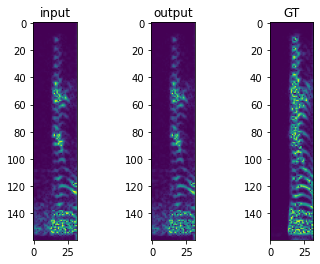

In [21]:
plt.figure()
ax1=plt.subplot(1,3,1)
ax1.imshow(img_test)
ax1.title.set_text("input")
ax2=plt.subplot(1,3,2)
ax2.imshow(out.cpu().numpy())
ax2.title.set_text("output")
ax3=plt.subplot(1,3,3)
ax3.imshow(img_label)
ax3.title.set_text("GT")

In [22]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["train loss","validation loss"])

NameError: name 'train_loss' is not defined

Buffer level processing with 10ms of input samples being buffered and fed to the feature extractor in every iteration

370.8074
(160, 3001)


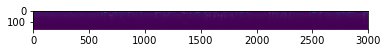

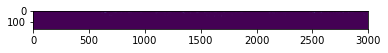

In [23]:
dirpath_daps="../dataset_daps/daps/"
input,sr=librosa.load(dirpath_daps+'/ipad_balcony1/f1_script1_ipad_balcony1.wav',duration=30,sr=8000)
stftx=librosa.stft(input,n_fft=318,hop_length=80)
magstftx,phasex=librosa.magphase(stftx)
segments=stftx.shape[1]//32
specs=np.zeros_like(magstftx)
outs=[]
for i in range(0,segments):
    spec=magstftx[:,32*i:32*i+32]
    img = torch.tensor(spec)
    img= torch.permute(img,(1,0))
    img=img.unsqueeze(0)
    img=img.to(dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        out=model(img*img)
    out=out.squeeze(0)
    out= torch.permute(out,(1,0))
    out=out.numpy()*spec
    outs.append(out)
    specs[:,32*i:32*i+32]=out*spec

specs=np.array(specs)
print(np.max(specs))

reconst=specs*phasex

plt.figure()
plt.imshow(magstftx)

plt.figure()
plt.imshow(specs)

print(stftx.shape)

istftx=librosa.istft(stftx,hop_length=80,n_fft=318)
reistftx=(1/80)*librosa.istft(reconst,hop_length=80,n_fft=318)

In [24]:
wav.write("./input.wav", 8000, input)
wav.write("./reconstructed.wav", 8000, reistftx)

In [25]:
class AdaptiveFilters():
    def __init__(self,mu,taps):
        self.e=0
        self.w=np.zeros((taps,1))
        self.xd=np.zeros((taps,1))
        self.mu=mu
        self.N=taps

In [155]:
class NLMS(AdaptiveFilters):
    #initialize
    def __init__(self,mu,taps):
        super().__init__(mu,taps)
        self.mu=mu
        self.N=taps
        self.e=0
        self.w=np.zeros((taps,1))
        self.xd=np.zeros((taps,1))
        self.yd=np.zeros((taps,1))

    #updates the filter sample by sample and updates weights sample by sample
    def run(self,x,out,d):
        N=self.N
        #udpate delay line 
        self.xd[0]=x
        #udpate delay line 
        self.yd[0]=out
        #compute filter output
        y = np.dot(self.w.T,self.xd)
        #compute input energy
        pw=np.linalg.norm(self.xd)
        pw=pw*pw
        #pw=pw*pw
        #calculate error
        e1 = d - y
        self.e=e1

        #normalize by input energy
        e= e1/(pw+0.001)
        #compute gradients
        Fw=self.mu*np.multiply(self.xd,e)
        
        Fw=Fw.reshape(Fw.shape[0],-1)
        #weight update
        self.w = self.w + Fw
    
        #filtered output post update
        y = np.dot(self.w.T,self.yd)
        #shift delay line
        self.xd[1:]=self.xd[:-1]
        self.yd[1:]=self.yd[:-1]

        #return current output sample, current error sample and current weights
        return (y,self.e,self.w)

In [156]:
d,sr= librosa.load('../dataset/AEC-Challenge/datasets/synthetic/nearend_mic_signal/nearend_mic_fileid_33.wav',sr=8000)
x,sr=librosa.load('../dataset/AEC-Challenge/datasets/synthetic/farend_speech/farend_speech_fileid_33.wav',sr=8000)
echo,sr=librosa.load('../dataset/AEC-Challenge/datasets/synthetic/echo_signal/echo_fileid_33.wav',sr=8000)
near_end,sr= librosa.load('../dataset/AEC-Challenge/datasets/synthetic/nearend_speech/nearend_speech_fileid_33.wav',sr=8000)

(160, 1001)


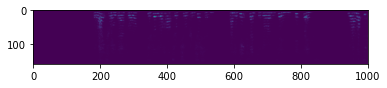

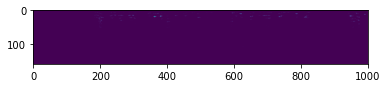

In [157]:
input=echo
stftx=librosa.stft(input,n_fft=318,hop_length=80)
magstftx,phasex=librosa.magphase(stftx)
segments=stftx.shape[1]//32
specs=np.zeros_like(magstftx)
outs=[]
for i in range(0,segments+1):
    spec=magstftx[:,32*i:32*i+32]
    img = torch.tensor(spec)
    img= torch.permute(img,(1,0))
    img=img.unsqueeze(0)
    img=img.to(dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        out=model(img*img)
    out=out.squeeze(0)  
    out= torch.permute(out,(1,0))
    out=out.numpy()*spec
    outs.append(out)
    specs[:,32*i:32*i+32]=out*spec

specs=np.array(specs)/np.max(specs)

reconst=specs*phasex

plt.figure()
plt.imshow(magstftx)

plt.figure()
plt.imshow(specs)

print(stftx.shape)

istftx=librosa.istft(stftx,hop_length=80,n_fft=318)
reistftx=librosa.istft(reconst,hop_length=80,n_fft=318)
reistftx=librosa.util.normalize(reistftx)

In [158]:
#test wrapper for NLMS filter on aec data for single talk case
taps=1024
lmscls= NLMS(0.1,taps)
w=np.zeros((taps,1))
y=np.zeros_like(x)
e=np.zeros_like(x)
x1=librosa.util.normalize(x)
d1=librosa.util.normalize(echo)
#a=[1,0.1]
#x1=scipy.signal.lfilter([1], a, x1)
#d1=scipy.signal.lfilter([1], a, d1)
#print(np.max(x1))
# a=librosa.lpc(d1,order=2)
# b = np.hstack([[0], -1 * a[1:]])
# dhat = scipy.signal.lfilter(b, [1], d1)
# d1=d1-dhat
# a1=librosa.lpc(x1,order=2)
# b1 = np.hstack([[0], -1 * a1[1:]])
# xhat = scipy.signal.lfilter(b1, [1], x1)
# x2=x1-xhat
# plt.figure()
# plt.plot(x1[:500])
# plt.plot(xhat[:500])
# plt.figure()
# plt.plot(x2[:500])

In [159]:
for i in range(0,len(x)):
    (y[i],e[i],w2)=lmscls.run(x1[i],x1[i],d1[i])

In [160]:
#test wrapper for NLMS filter on aec data for single talk case
taps=1024
lmscls= NLMS(0.1,taps)
w1=np.zeros((taps,1))
y1=np.zeros_like(x)
e1=np.zeros_like(x)
d1=scipy.signal.lfilter([1], a, reistftx)
for i in range(0,len(reistftx)):
    (y1[i],e1[i],w3)=lmscls.run(x1[i],x1[i],d1[i])

Text(0.5, 1.0, 'near end signal')

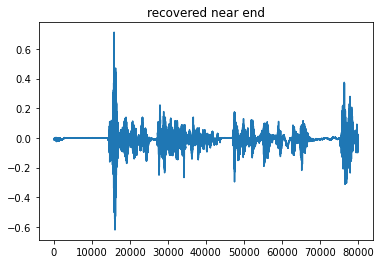

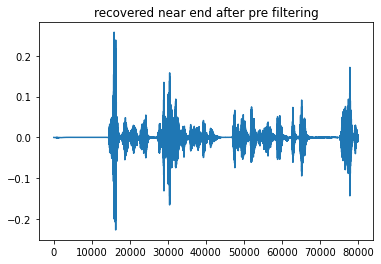

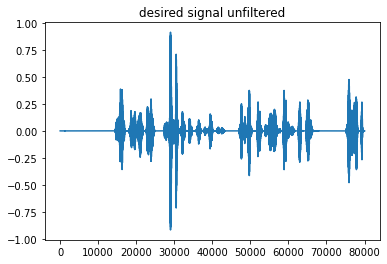

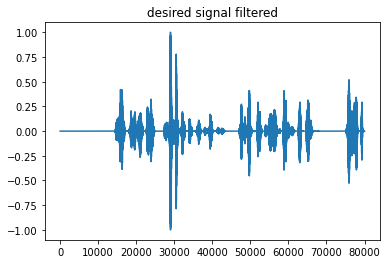

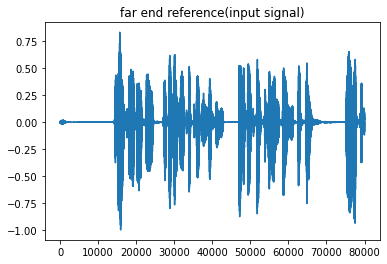

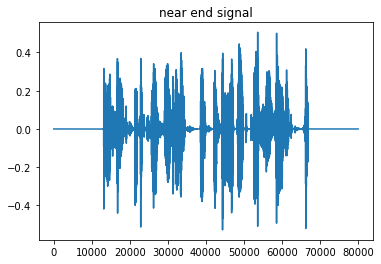

In [149]:
plt.figure()
plt.plot(e)
plt.title("recovered near end")
plt.figure()
plt.plot(e1)
plt.title("recovered near end after pre filtering")
plt.figure()
plt.plot(d1)
plt.title("desired signal unfiltered")
plt.figure()
plt.plot(reistftx)
plt.title("desired signal filtered")
plt.figure()
plt.plot(x1)
plt.title("far end reference(input signal)")
plt.figure()
plt.plot(near_end)
plt.title("near end signal")

In [108]:
wav.write("./nlms_er.wav", 8000, e)
wav.write("./nlms_wprefilter.wav", 8000, e1)

In [153]:
pwe1=np.linalg.norm(e)
pwe1=pwe1*pwe1
pwecho=np.linalg.norm(d1)
pwecho=pwecho*pwecho
erle=10*np.log10(pwe1/pwecho)
print("ERLE without pre-filtering",erle)

ERLE without pre-filtering -3.6192691341517333


In [154]:
pwe1=np.linalg.norm(e1)
pwe1=pwe1*pwe1
pwecho=np.linalg.norm(d1)
pwecho=pwecho*pwecho
erle=10*np.log10(pwe1/pwecho)
print("ERLE with pre-filtering",erle)

ERLE with pre-filtering -12.074967225378188
